<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/heat_equation_parallel_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallelizing the Heat Equation

* We previously saw some examples of solving the time-dependent heat equation in NumPy. Here, we'll consider how to make this code faster by parallelizing it using MPI.

## Idea

* The basic idea here is that we can break down the spatial domain into chunks and have each process responsible for computing the diffusion stencil for its own chunk.
* Computing the diffusion stencil at a given cell involves the cells adjacent to it.
* For most cells in the domain, this is fine, but what do we do at the edge of chunks?
* We can't directly access data from a different, chunk, so we can use MPI to communicate between chunks.
* In practice each process is responsible for doing compuatations on a given set of rows. Each row contains a subset of rows in the domain, plus top and bottom "halo" rows.
* Rows from other ranks can be copied into these halos so that each process has all of the information it needs to compute the diffusion stencil on its chunk of the domain.

## Full Code
The full code is presented here, but we'll break down each function in turn.

In [ ]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import argparse

def init_field(nx, ny, hot=1.0, block=10):
    """
    Initialize a 2D field with a hot square in the center.

    Parameters
    ----------
    nx : int
        Number of columns.
    ny : int
        Number of rows.
    hot : float, optional
        Value to assign inside the hot block (default 1.0).
    block : int, optional
        Approximate size of the hot block edge (default 10).

    Returns
    -------
    u : ndarray of shape (ny, nx)
        Array with the hot block set to `hot`, rest zero.
    """
    u = np.zeros((ny, nx), dtype=np.float64)
    cx, cy = nx // 2, ny // 2
    b = block // 2
    u[cy-b:cy+b, cx-b:cx+b] = hot
    return u

def halo_exchange(comm, u):
    """
    Exchange top/bottom halo rows with neighboring ranks.

    Parameters
    ----------
    comm : MPI.Comm
        MPI communicator.
    u : ndarray of shape (my+2, nx)
        Local array with one ghost row at top and bottom.
    """
    rank = comm.Get_rank()
    size = comm.Get_size()

    up   = rank - 1 if rank > 0 else MPI.PROC_NULL
    down = rank + 1 if rank < size - 1 else MPI.PROC_NULL

    comm.Sendrecv(u[1, :],  dest=up,   sendtag=0,
                  recvbuf=u[-1, :], source=down, recvtag=0)
    comm.Sendrecv(u[-2, :], dest=down, sendtag=1,
                  recvbuf=u[0, :],    source=up,   recvtag=1)

def run_sim(comm, u0=None, steps=500, alpha=0.24):
    """
    Distribute the initial field, run Jacobi iterations, and gather results.

    Parameters
    ----------
    comm : MPI.Comm
        MPI communicator.
    u0 : ndarray or None
        Full initial condition on root; None on other ranks.
    steps : int, optional
        Number of Jacobi iterations (default 500).
    alpha : float, optional
        Diffusion coefficient for the update (default 0.24).

    Returns
    -------
    U_final : ndarray or None
        Global field on root, None on other ranks.
    """
    rank = comm.Get_rank()
    size = comm.Get_size()

    if rank == 0:
        ny, nx = map(int, u0.shape)
    else:
        ny, nx = None, None
    ny, nx = comm.bcast((ny, nx), root=0)

    edges = np.floor(np.linspace(0, ny, size + 1)).astype(np.int64)
    starts = edges[:-1]
    stops  = edges[1:]
    y0, y1 = starts[rank], stops[rank]
    my = y1 - y0

    if rank == 0:
        counts = (stops - starts) * nx
        displs = starts * nx
        sendbuf = [u0, counts, displs, MPI.DOUBLE]
    else:
        sendbuf = None

    local = np.empty((my, nx), dtype=np.float64)
    comm.Scatterv(sendbuf, local, root=0)

    u = np.zeros((my + 2, nx), dtype=np.float64)
    u[1:-1, :] = local

    for _ in range(steps):
        halo_exchange(comm, u)
        un = u.copy()
        center = u[1:-1, 1:-1]
        left   = u[1:-1, :-2]
        right  = u[1:-1, 2:]
        up     = u[0:-2, 1:-1]
        down   = u[2:, 1:-1]
        un[1:-1, 1:-1] = center + alpha*(left + right + up + down - 4.0*center)
        u = un

    interior = u[1:-1, :]

    if rank == 0:
        recvbuf = np.empty((ny, nx), dtype=u.dtype)
        mpi_dt = MPI._typedict[interior.dtype.char]
        comm.Gatherv(interior, [recvbuf, counts, displs, mpi_dt], root=0)
        U_final = recvbuf
    else:
        comm.Gatherv(interior, None, root=0)
        U_final = None

    return U_final

## 1. Initial Condition

Let's look at the entry point code. First, it just gets the communicator and the rank. Then the rank 0 process creates an initial condition.


```python
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

nx, ny = 1024, 1024
if rank == 0:
    u0 = init_field(nx=nx, ny=ny, hot=1.0, block=250)
else:
    u0 = None
```
Next, every rank calls this `run_sim` function, which runs the simulation for a given number of time steps with the given initial condition (which is really defined only on rank 0).

```python
u1 = run_sim(comm, u0=u0, steps=5000, alpha=0.24)
```

## 2. Run Simulation Function
Next, let's take a look at the `run_sim` function. The first thing that happens is that the rank 0 process figures out the shape of the initial condition and broadcasts it to the other ranks.

```python
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    ny, nx = map(int, u0.shape)
else:
    ny, nx = None, None
ny, nx = comm.bcast((ny, nx), root=0)
```



Based on the size of the number of grid cells in the domain and number of processes, we compute the start and end indexes of each chunk belonging to all processes. Then we get the start and stop index for the rank's chunk and compute its size `my`.

```python
edges = np.floor(np.linspace(0, ny, size + 1)).astype(np.int64)
starts = edges[:-1]
stops  = edges[1:]
y0, y1 = starts[rank], stops[rank]
my = y1 - y0
```

Once we've figured out how to break up the domain, we can split up the initial condition by scattering it among all ranks. Note that `Scatterv` allows scattering of different sized arrays to each process. This is necessary because the last chunk could have a different size than the rest.
```python
# 3) Prepare Scatterv
if rank == 0:
    counts = (stops - starts) * nx              # elements per rank
    displs = starts * nx                        # element offsets
    sendbuf = [u0, counts, displs, MPI.DOUBLE]  # explicit type for clarity
else:
    sendbuf = None

# 4) Receive my interior rows (no halos yet)
local = np.empty((my, nx), dtype=np.float64)
comm.Scatterv(sendbuf, local, root=0)
```
At this point in the code, every rank has receieved its local chunk of the initial condition. We create an array `u` that will store the local solution, including two halo rows on the top and bottom. The initial condition is copied into the interior of tis array.

```python
# 5) Allocate local with halos and copy interiors into rows 1..my
u = np.zeros((my + 2, nx), dtype=np.float64)
u[1:-1] = local
```

### 2.1 Simulation Loop
After distributing the initial condition and defining an array to store the local solution, we launch into the simulation loop.

```python
 for _ in range(steps):
    # exchange halos each step
    halo_exchange(comm, u)

    un = u.copy()

    center = u[1:-1, 1:-1]
    left   = u[1:-1, :-2]   
    right  = u[1:-1, 2:]   
    up     = u[0:-2, 1:-1]
    down   = u[2:, 1:-1]
    
    un[1:-1, 1:-1] = center + alpha*(left + right + up + down - 4.0*center)
    u = un
```
This is mostly going to look very familar with the exception of calling `halo_exchange` at the beginning, as this just involves copying the initial condition, then computing the new value of all interior cells using the typical diffusion stencil. So what does `halo_exchange` do?

### 2.2 Halo Exchange
The `halo_exchange` function is responsible for sending information about the rank's local solution to other ranks responsible for adjacent chunks of the domain. If the chunk belonging to a given rank has a chunk above it, it will send an array containing the first row it owns (that is its first non-halo row in its local solution) to the chunk above it. In turn the chunk above it will receive that information in its bottom-most halo row. The process is similar if the rank has another chunk below it. The chunk will send its bottom-most non-halo row to the rank below it. That rank will receive it in its top halo row.

```python

def halo_exchange(comm, u):
    """Blocking 1D (row-wise) halo exchange for u of shape (my+2, nx)."""
    rank = comm.Get_rank()
    size = comm.Get_size()
    my, nx = u.shape[0] - 2, u.shape[1]

    up   = rank - 1 if rank > 0 else MPI.PROC_NULL
    down = rank + 1 if rank < size - 1 else MPI.PROC_NULL

    # Send first interior row up; recv bottom ghost from down
    comm.Sendrecv(u[1, :],  dest=up,   sendtag=0,
                  recvbuf=u[-1, :], source=down, recvtag=0)
    # Send last interior row down; recv top ghost from up
    comm.Sendrecv(u[-2, :], dest=down, sendtag=1,
                  recvbuf=u[0, :],    source=up,   recvtag=1)
```

Note that if a rank doesn't have a chunk above / below it, then the up / down rank is defined as `MPI.PROC_NULL`. This is a convenient way to basically say that if there is no rank to send anything to, so the send won't do anything.


## 3. Assembling a Global Solution From Local Solutions

Now we're nearly done with our simulation code! However, if we'd like to plot our solution we need to stitch together all of the local solutions into a global solution . We can accomplish this usng a `Gatherv` operation, which is essentially the reverse of the `Scatterv` we used to split the initial condition into chunks earlier.

```python
 if rank == 0:
        recvbuf = np.empty((ny, nx), dtype=u.dtype)  # global stitched array
        # If you want to be explicit about type:
        mpi_dt = MPI._typedict[interior.dtype.char]
        comm.Gatherv(interior, [recvbuf, counts, displs, mpi_dt], root=0)
    else:
        # Non-root: counts/displs/recvbuf are None; only send your interior
        comm.Gatherv(interior, None, root=0)
```


Lastly, rank 0 will return the stitched together global solution and every other rank will return `None`.

```python
# Now rank 0 has the full field in `recvbuf`
if rank == 0:
    U_final = recvbuf
else:
    U_final = None

return None
```

## Benchmarking MPI Code

So, how much of a performance advantage do we get from using more processes? To find out, let's do some detailed benchmarking. First, we'll alter the entry point as follows.

In [ ]:

if __name__ == "__main__":
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    parser = argparse.ArgumentParser()
    parser.add_argument("--measure", action="store_true",
                        help="Run timed trials and print CSV (rank 0 only).")
    parser.add_argument("--repeat", type=int, default=1,
                        help="Number of timed trials to run.")
    parser.add_argument("--nx", type=int, default=1500)
    parser.add_argument("--ny", type=int, default=1500)
    parser.add_argument("--steps", type=int, default=2500)
    parser.add_argument("--alpha", type=float, default=0.24)
    parser.add_argument("--csv_header", action="store_true",
                        help="Print CSV header (rank 0 only).")
    args = parser.parse_args()

    if args.measure:
        # optional header
        if rank == 0 and args.csv_header:
            print("n,nx,ny,steps,alpha,trial,wall_max_s,wall_mean_rank_s,wall_std_rank_s,time_per_core_s")

        for trial in range(args.repeat):
            # fresh IC each trial (keeps runs comparable)
            u0 = init_field(nx=args.nx, ny=args.ny, hot=1.0, block=min(args.nx, args.ny)//4) if rank == 0 else None

            comm.Barrier()
            t0 = MPI.Wtime()
            _ = run_sim(comm, u0=u0, steps=args.steps, alpha=args.alpha)
            comm.Barrier()
            t1 = MPI.Wtime()

            # rank-local elapsed
            elapsed = t1 - t0

            # summarize across ranks
            wall_max = comm.allreduce(elapsed, op=MPI.MAX)  # job wall time
            wall_sum = comm.allreduce(elapsed, op=MPI.SUM)
            wall_sumsq = comm.allreduce(elapsed * elapsed, op=MPI.SUM)
            wall_mean_rank = wall_sum / size
            var = max(0.0, wall_sumsq / size - wall_mean_rank * wall_mean_rank)
            wall_std_rank = var ** 0.5

            if rank == 0:
                time_per_core = wall_max / size
                print(f"{size},{args.nx},{args.ny},{args.steps},{args.alpha},{trial},"
                      f"{wall_max:.6f},{wall_mean_rank:.6f},{wall_std_rank:.6f},{time_per_core:.6f}",
                      flush=True)
    else:
        # normal, single run (no timing/CSV)
        nx, ny = 1024, 1024
        u0 = init_field(nx=nx, ny=ny, hot=1.0, block=250) if rank == 0 else None
        u1 = run_sim(comm, u0=u0, steps=5000, alpha=0.24)
        if rank == 0:
            plt.imshow(u1)
            plt.colorbar()
            plt.show()



### Command Line Arguments

Let's break this down into pieces. First, add flags to pass in some model parameters as command line arguments like grid size and the number of time steps.


```python
parser = argparse.ArgumentParser()
parser.add_argument("--measure", action="store_true",
                    help="Run timed trials and print CSV (rank 0 only).")
parser.add_argument("--repeat", type=int, default=1,
                    help="Number of timed trials to run.")
parser.add_argument("--nx", type=int, default=1500)
parser.add_argument("--ny", type=int, default=1500)
parser.add_argument("--steps", type=int, default=2500)
parser.add_argument("--alpha", type=float, default=0.24)
parser.add_argument("--csv_header", action="store_true",
                    help="Print CSV header (rank 0 only).")
args = parser.parse_args()
```
 In addition to adding flags for model parameters, we include a few optional flags that are used for benchmarking. For example adding the `--measure` flag will enable benchmarking mode and `--repeat` can be used to specify the number of times a model run is repeated when benchmarking so we can compute timing statistics.


### Repeated Trials and Statistics

We perform a number of model runs specified by command line argument or 1 run by default. In each trial we reset the model with a new initial condition.
```python
for trial in range(args.repeat):
    # fresh IC each trial (keeps runs comparable)
    u0 = init_field(nx=args.nx, ny=args.ny, hot=1.0, block=min(args.nx, args.ny)//4) if rank == 0 else None
```
An important consideration when timing MPI code is that each process can have a slightly different completion time. Moreover the usual Python `time` module tends to be inaccurate, so we need a different approach for benchmarking. The code below uses `comm.Barrier()` to block until all processes are synchronized (that is they've reached the same point in the code). Then we use `MPI.Wtime()` to get the current wall time and run the simulation.
```python
comm.Barrier()
t0 = MPI.Wtime()
_ = run_sim(comm, u0=u0, steps=args.steps, alpha=args.alpha)
```

After the simulation completes, we again synchronize all processes, get the wall time again, and see how long the current process took to finish:
```python
comm.Barrier()
t1 = MPI.Wtime()
# rank-local elapsed
elapsed = t1 - t0
```


Since each rank has its own elapsed time, we can do some `reduce` operations to compute some summary statistics.

```python
# summarize across ranks
wall_max = comm.allreduce(elapsed, op=MPI.MAX)  # job wall time
wall_sum = comm.allreduce(elapsed, op=MPI.SUM)
wall_sumsq = comm.allreduce(elapsed * elapsed, op=MPI.SUM)
wall_mean_rank = wall_sum / size
var = max(0.0, wall_sumsq / size - wall_mean_rank * wall_mean_rank)
wall_std_rank = var ** 0.5
```
Finally, the root node just prints out the results.
```python
if rank == 0:
    time_per_core = wall_max / size
    print(f"{size},{args.nx},{args.ny},{args.steps},{args.alpha},{trial},"
          f"{wall_max:.6f},{wall_mean_rank:.6f},{wall_std_rank:.6f},{time_per_core:.6f}",
          flush=True)
```

## Performance v. Cores
We now have some code to benchmark some simulations for a given number of cores. To compare how the timing statistics vary based on the number of cores we use, we can define a simple bash script.

```bash
echo "n,nx,ny,steps,alpha,trial,wall_max_s,wall_mean_rank_s,wall_std_rank_s,time_per_core_s" > results.csv

for n in 1 2 4 8 16; do
  mpiexec -n $n \
    python parallel_heat.py --measure --repeat 5 >> results.csv
done
```

This code will perform benchmarks for a variable number of cores from 1 to 16 and write the statistics for each benchmark trial to a CSV file. Plotting the results we get something like this.

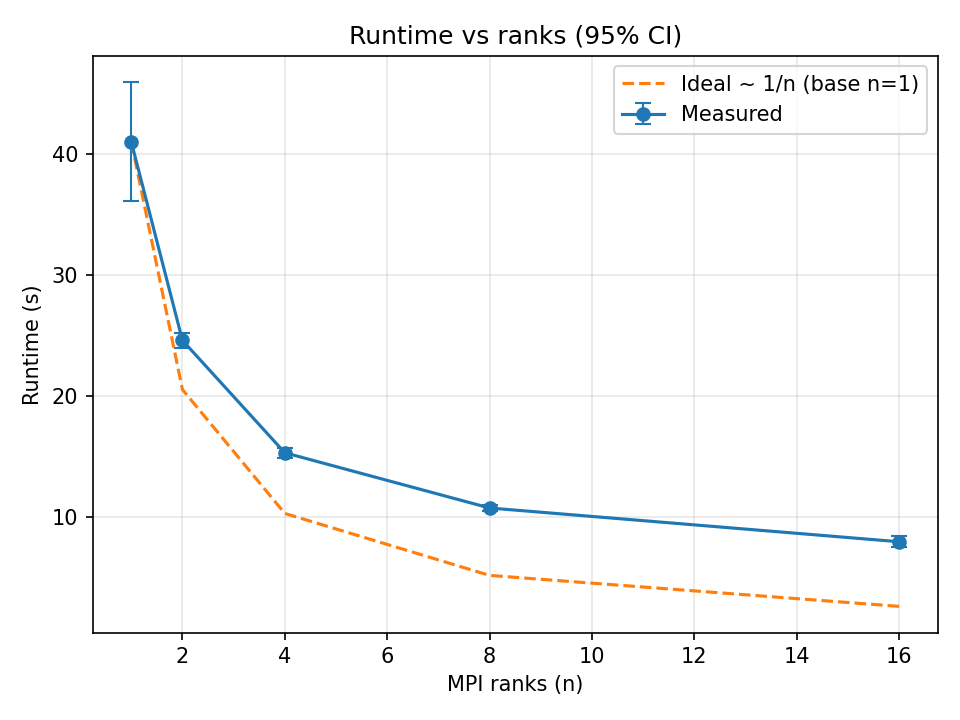